<center><h1>Supervised vs Semisupervised Learning</h1></center>

Machine learning approaches rely heavily on supervised and unsupervised methods. It's possible to combine supervised and semi-supervised learning in a new sort of learning called semi-supervised learning.

Semi-supervised learning comes in handy when there is a lot of variation in the dataset. A model that works well with labels belonging to the majority class is the goal. Using a threshold, we can determine whether a model has to be adjusted in order for it to be considered fraudulent or not.

<h2> Supervised Learning with Random Forest  and XGBoost </h2>

Random forest and XGBoost are great algorithms for unbalanced datasets validation. Firstly, 
let's do a data preparation on this base.



<h3> DataPrep </h3>
Firstly, we will load all the required libraries.

In [2]:
from sklearn.preprocessing import RobustScaler #robust normlization for outliers
import sklearn.metrics as metrics #metrics librry
import seaborn as sns # for intractve graphs
from sklearn.ensemble import RandomForestClassifier #Random Forest
import matplotlib.pyplot as plt #for visualization
from xgboost.sklearn import XGBClassifier #XGBoost
from sklearn.metrics import classification_report
from xgboost import plot_importance #feature rimportance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Model, load_model
from keras.layers import Input,Dense, BatchNormalization #layers of autoencoder
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping #callbacks
from keras import regularizers #regularization
from sklearn.ensemble import IsolationForest #Isolation Forest
from sklearn.mixture import GaussianMixture #Gaussian Mixture
from imblearn.over_sampling import SMOTE
import os

## GET DATA


In [4]:
dataframe = pd.read_csv("./creditcard.csv")

<h3> Robust Normalization </h3>

The Robust normalization is a scale features using statistics that are robust to outliers and in our model perform better than Standar Scaler. Let's apply Robust normalization and shuffle the data points.


In [5]:
RS=RobustScaler()
dataframe['Amount'] = RS.fit_transform(dataframe['Amount'].values.reshape(-1, 1))
dataframe['Time'] = RS.fit_transform(dataframe['Time'].values.reshape(-1, 1))
df = dataframe.sample(frac=1, random_state = 42)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,-0.507372,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,4.781527,1
49906,-0.474994,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,6.960386,0
29474,-0.578108,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0.125760,0
276481,0.968421,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.286453,0
278846,0.984281,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.294977,0


Counting the data points, we have:

Normal 99.83 % of the dataset
Fraud 0.17 % of the dataset


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

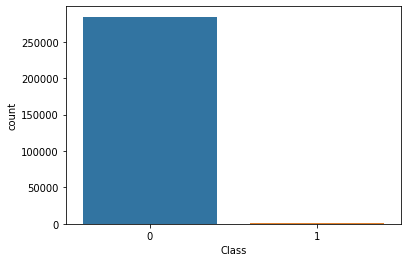

In [6]:
print('Normal', round(
        df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Fraud', round(
        df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')
sns.countplot("Class",data=df)


<h3> Undersampling </h3>

Since the dataset is extremely unbalanced (492 frudes and 284315 normal data points), we need to undersample the normal data points. With the procedure below, we will get a 9:1 ratio dataset between normal data points and fraud.

In [11]:
fraud_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
fraud_df_test = df.loc[df['Class'] == 1][int(492*0.8):]


#undersampling of the data. Fraude represent 10% of base now
normal_df_train_sup= df.loc[df['Class'] == 0][:int(492*0.8*9*3)]
normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9*3:int(492*0.8*9*3)+int(284800*0.2)]
new_df_train = pd.concat([pd.DataFrame(normal_df_train_sup), fraud_df_train])

#oversampling of the data. The number of Fraud was twiced
sm = SMOTE(k_neighbors=5, random_state=0, n_jobs=8)

normal_df_train_sup, fraud_df_train = sm.fit_resample(new_df_train.drop('Class', axis=1), new_df_train['Class'])
fraud_df_train = pd.DataFrame(fraud_df_train.transpose()).rename(columns={0:"Class"})
new_df_train = pd.concat([pd.DataFrame(normal_df_train_sup), fraud_df_train ], axis=1)
new_df_train.columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount','Class']
new_df_test = pd.concat([pd.DataFrame(normal_df_test), fraud_df_test])




In [12]:
new_df_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.474994,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,6.960386,0
1,-0.578108,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0.125760,0
2,0.968421,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.286453,0
3,0.984281,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.294977,0
4,-0.197535,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,...,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,1.089918,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21249,-0.006095,-3.437567,2.374978,-3.278520,1.505312,-2.004501,-1.304231,-3.559626,1.187220,0.125315,...,1.082633,0.137010,0.314417,-0.246932,0.086216,-0.054019,-0.506573,0.311101,-0.281737,1
21250,0.747149,-0.501778,-3.389334,-2.799240,0.237340,-1.048717,-0.722824,2.048445,-0.681129,1.179600,...,0.537440,0.287833,-0.737201,-0.054008,-0.282801,-0.936891,0.040735,0.184536,13.766039,1
21251,-0.566974,-3.208849,2.793113,-3.200891,1.682539,-1.583350,-1.707728,-3.214435,-1.643008,-0.554436,...,1.890613,-0.813719,-0.308292,0.085871,-0.076189,0.200321,-0.170942,-0.598575,0.432023,1
21252,-0.159737,-0.405103,0.904271,0.817027,0.114093,0.448797,-1.259451,0.946665,-0.141073,-0.284320,...,0.014225,-0.063054,-0.179898,0.280574,0.420395,-0.508494,-0.018459,-0.000427,0.061176,1



For the test base, we will use the same proportion as the original base.

Normal 99.83 % of the test dataset
Fraud 0.17 % of the test dataset


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Count - Test Data')

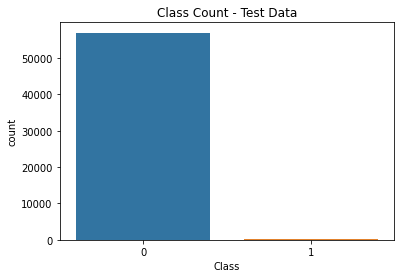

In [13]:
print('Normal', round(
        new_df_test['Class'].value_counts()[0]/len(new_df_test)*100, 2), '% of the test dataset')
print('Fraud', round(
        new_df_test['Class'].value_counts()[1]/len(new_df_test)*100, 2), '% of the test dataset')
sns.countplot("Class",data=new_df_test).set_title('Class Count - Test Data')

Setting the training and test bases:

Normal 50.0 % of the train dataset
Fraude 50.0 % of the train dataset


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Count - Train Data')

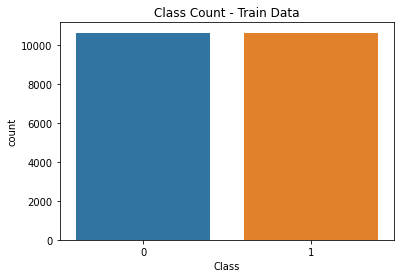

In [14]:

X_train_sup = new_df_train.drop('Class', axis=1)
y_train = new_df_train['Class']

X_test=new_df_test.drop('Class', axis=1)
y_test=new_df_test['Class']
new_df_train.head()

print('Normal', round(
        pd.Series(y_train).value_counts()[0]/len(X_train_sup)*100, 2), '% of the train dataset')
print('Fraude', round(
        pd.Series(y_train).value_counts()[1]/len(X_train_sup)*100, 2), '% of the train dataset')
sns.countplot("Class",data=new_df_train).set_title('Class Count - Train Data')

<h3> Training Random Forest and XGBoost </h3>



We will now train or dataset, use random forest and XGBoost models, with gridsearch optimized hyperparameters.

In [15]:
#grid_search
"""
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, verbose=2, n_jobs = -1)
rf_random.fit(X_res,y_res)
rf_random.best_params_
"""

rfc = RandomForestClassifier(n_estimators = 1600,
 min_samples_split = 2,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = 100,
 bootstrap = False)
;

xgb = XGBClassifier(min_child_weight = 5,
 max_depth=12,
 learning_rate= 0.1,
 gamma= 0.2,
 colsample_bytree= 0.7)

<h3> Fit with Random Forest </h3>
To get the confusion matrix with the best metric f2, let's predict the probability that the data points are in a given class and apply a threshold that will find the adjustment we need.

In [16]:
rfc.fit(X_train_sup,y_train)
prediçtion_rfc = rfc.predict_proba(X_test.values)
tresholds = np.linspace(0 , 1 , 200)
scores_rfc=[]
for treshold in tresholds:
    y_hat_rfc = (prediçtion_rfc[:,0] < treshold).astype(int)
    scores_rfc.append([metrics.recall_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_rfc, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_rfc, y2=y_test)])
scores_rfc = np.array(scores_rfc)
final_tresh = tresholds[scores_rfc[:, 2].argmax()]
y_hat_rfc = (prediçtion_rfc < final_tresh).astype(int)
cm_rfc = metrics.confusion_matrix(y_test,y_hat_rfc[:,0])
best_score = scores_rfc[scores_rfc[:, 2].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
cohen_kappa_score = best_score[3]

print('The recall score is: %.3f' % recall_score)
print('The precision score is: %.3f' % precision_score)
print('The f2 score is: %.3f' % fbeta_score)
print('The Kappa score is: %.3f' % cohen_kappa_score)

<h3> Feature Importance </h3>

Here we can see which variables influenced the model performance the most.

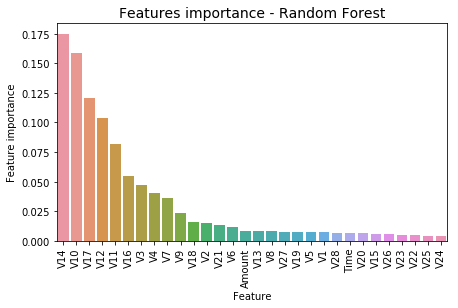

In [ ]:
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance - Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  


In [ ]:

y_true = y_test
y_pred_rfc = y_hat_rfc[:,0]
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_true, y_pred_rfc, target_names=target_names))

                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56976
 class 1 (Fraud)       0.91      0.85      0.88        99

        accuracy                           1.00     57075
       macro avg       0.96      0.92      0.94     57075
    weighted avg       1.00      1.00      1.00     57075




With the confusion matrix, we can get a better view of how the model classified the data points:

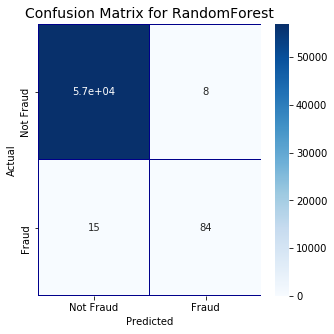

In [ ]:
cm = pd.crosstab(y_test, y_pred_rfc, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for RandomForest', fontsize=14)
plt.show()

<h3> Trade off Between Precision and Recall </h3>

There is a trade-off between precision and recall as we change the threshold. At a threshold of zero, all values are 'fraud', in which case the precision would be 1 and the recall would be the lowest possible, because in the denominator of this metric the number of false negative would be maximum. The opposite would be true for a threshold of 1: all values rated 'normal' would have recall 1, as it has no false negative, but precision would be as low as possible, as it would have the maximum number of false positive.

We will choose the threshold where the f2-score is maximum.

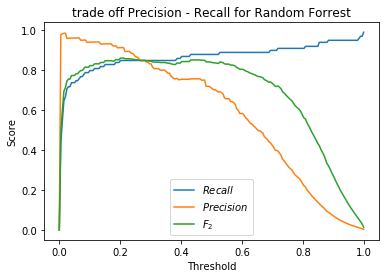

In [ ]:
#precision_recall
plt.plot(tresholds, scores_rfc[:, 0], label='$Recall$')
plt.plot(tresholds, scores_rfc[:, 1], label='$Precision$')
plt.plot(tresholds, scores_rfc[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('trade off Precision - Recall for Random Forrest')
plt.show()

<h2> Fit with XGBoost Classifier </h2>
Let's set the parameters for the model and initialize the model, 
analogously to what we did before:

In [ ]:
xgb = XGBClassifier(min_child_weight = 5,
 max_depth=12,
 learning_rate= 0.1,
 gamma= 0.2,
 colsample_bytree= 0.7)

xgb.fit(X_train_sup, y_train)

prediction_xgb = xgb.predict_proba(X_test)
tresholds = np.linspace(0 , 1 , 200)
scores_xgb=[]
for treshold in tresholds:
    y_hat_xgb = (prediction_xgb[:,0] < treshold).astype(int)
    scores_xgb.append([metrics.recall_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_xgb, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_xgb, y2=y_test)])  
scores_xgb = np.array(scores_xgb)
final_tresh = tresholds[scores_xgb[:, 2].argmax()]
y_hat_xgb = (prediction_xgb < final_tresh).astype(int)
best_score_xgb = scores_xgb[scores_xgb[:, 2].argmax(),:]
recall_score_xgb = best_score_xgb[0]
precision_score_xgb = best_score_xgb[1]
fbeta_score_xgb = best_score_xgb[2]
cohen_kappa_score_xgb = best_score_xgb[3]

print('The recall score is": %.3f' % recall_score_xgb)
print('The precision score is": %.3f' % precision_score_xgb)
print('The f2 score is": %.3f' % fbeta_score_xgb)
print('The Kappa score is": %.3f' % cohen_kappa_score_xgb)

The recall score is": 0.869
The precision score is": 0.768
The f2 score is": 0.846
The Kappa score is": 0.815


                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56976
 class 1 (Fraud)       0.77      0.87      0.82        99

        accuracy                           1.00     57075
       macro avg       0.88      0.93      0.91     57075
    weighted avg       1.00      1.00      1.00     57075



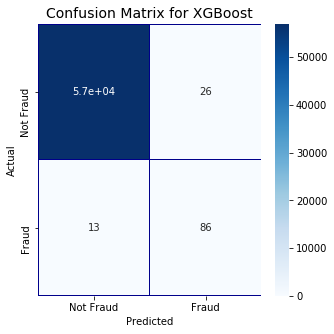

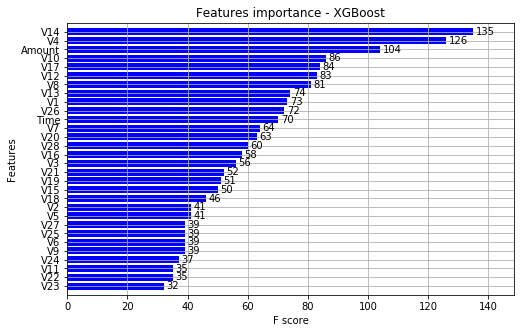

In [ ]:

y_true = y_test
y_pred_xgb = y_hat_xgb[:,0]
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_true, y_pred_xgb, target_names=target_names))
cm = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for XGBoost', fontsize=14)
plt.show()
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
plot_importance(xgb, height=0.8, title="Features importance - XGBoost", ax=ax, color="blue") 
plt.show()

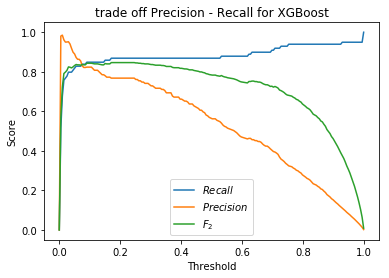

In [ ]:
#precision_recall
plt.plot(tresholds, scores_xgb[:, 0], label='$Recall$')
plt.plot(tresholds, scores_xgb[:, 1], label='$Precision$')
plt.plot(tresholds, scores_xgb[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('trade off Precision - Recall for XGBoost')
plt.show()

<h3>Shuffle 10 times the dataset</h3> 
Both the algorithms, random forest andt XGBoost algorithm, perfomed very close, according to the f2 metric. To avoid overfitting, we will shuffle our data points another 10 times and average the metrics on each shuffle. 

In [ ]:
scores=[]
for i in  list(range(1,11)):
    df = dataframe.sample(frac=1, random_state = i)
    #divid frauds in train (80%) and test (20%)
    fraud_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
    fraud_df_test = df.loc[df['Class'] == 1][int(492*0.8):]

    # undersmpling of norml data: the normal data represent 90% of the new base
    normal_df_train_sup= df.loc[df['Class'] == 0][:int(492*0.8*9)]
    normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9:int(492*0.8*9)+int(284807*0.2)]
    new_df_train = pd.concat([normal_df_train_sup, fraud_df_train])
    new_df_test = pd.concat([normal_df_test, fraud_df_test])

    X_train_sup = new_df_train.drop('Class', axis=1)
    y_train = new_df_train['Class']
    X_test=new_df_test.drop('Class', axis=1)
    y_test=new_df_test['Class']

    rfc.fit(X_train_sup,y_train)
    prediction_rfc = rfc.predict_proba(X_test.values)
    tresholds = np.linspace(0 , 1 , 200)
    scores_rfc=[]
    for treshold in tresholds:
        y_hat_rfc = (prediction_rfc[:,0] < treshold).astype(int)
        scores_rfc.append([metrics.recall_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_rfc, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_rfc, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_rfc, y2=y_test)])
    scores_rfc = np.array(scores_rfc)
    #choice the model with best f2 score
    best_scores = scores_rfc[scores_rfc[:, 2].argmax(),:]
    scores.append(best_scores)
    print('recall, precision, f2, kappa in shuffle %1d' %i)
    print(best_scores)

    recall_score_rfc = np.mean(scores, axis=0)[0]
    precision_score_rfc = np.mean(scores,axis=0)[1]
    fbeta_score_rfc = np.mean(scores, axis=0)[2]
    cohen_kappa_score_rfc = np.mean(scores, axis=0)[3]
print('--------------------------------------------------')
print("for the random forest algorithm:")
print('The recall score is: %.3f' % recall_score_rfc)
print('The precision score is: %.3f' % precision_score_rfc)
print('The f2 score is: %.3f' % fbeta_score_rfc)
print('The Kappa score is: %.3f' % cohen_kappa_score_rfc)

recall, precision, f2, kappa in shuffle 1
[0.82828283 0.82828283 0.82828283 0.8279844 ]
recall, precision, f2, kappa in shuffle 2
[0.84848485 0.81553398 0.84168337 0.83138485]
recall, precision, f2, kappa in shuffle 3
[0.83838384 0.80582524 0.83166333 0.82146631]
recall, precision, f2, kappa in shuffle 4
[0.76767677 0.82608696 0.77868852 0.79546969]
recall, precision, f2, kappa in shuffle 5
[0.88888889 0.83018868 0.87649402 0.85828233]
recall, precision, f2, kappa in shuffle 6
[0.7979798  0.82291667 0.80284553 0.80993174]
recall, precision, f2, kappa in shuffle 7
[0.82828283 0.9010989  0.84188912 0.86293011]
recall, precision, f2, kappa in shuffle 8
[0.83838384 0.81372549 0.83333333 0.82556351]
recall, precision, f2, kappa in shuffle 9
[0.88888889 0.83018868 0.87649402 0.85828233]
recall, precision, f2, kappa in shuffle 10
[0.86868687 0.86       0.86693548 0.86408463]
--------------------------------------------------
for the random forest algorithm:
The recall score is: 0.839
The prec

In [ ]:
scores=[]

for i in  list(range(1,11)):
    df = dataframe.sample(frac=1, random_state = i)
    #divid frauds in train (80%) and test (20%)
    fraud_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
    fraud_df_test = df.loc[df['Class'] == 1][int(492*0.8):]

    # undersmpling of norml data: the normal data represent 90% of the new base
    normal_df_train_sup= df.loc[df['Class'] == 0][:int(492*0.8*9)]
    normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9:int(492*0.8*9)+int(284807*0.2)]
    new_df_train = pd.concat([normal_df_train_sup, fraud_df_train])
    new_df_test = pd.concat([normal_df_test, fraud_df_test])
    
    X_train_sup = new_df_train.drop('Class', axis=1)
    y_train = new_df_train['Class']
    X_test=new_df_test.drop('Class', axis=1)
    y_test=new_df_test['Class']

    xgb.fit(X_train_sup.values,y_train)
    prediction_xgb = xgb.predict_proba(X_test.values)
    tresholds = np.linspace(0 , 1 , 200)
    scores_xgb=[]
    for treshold in tresholds:
        y_hat_xgb = (prediction_xgb[:,0] < treshold).astype(int)
        scores_xgb.append([metrics.recall_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_xgb, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_xgb, y2=y_test)])
    scores_xgb = np.array(scores_xgb)
    #choice the model with best f2 score
    best_scores = scores_xgb[scores_xgb[:, 2].argmax(),:]
    
    print('recall, precision, f2, kappa in shuffle %1d' %i)
    print(best_scores)
    scores.append(best_scores)
    
recall_score_xgb = np.mean(scores, axis=0)[0]
precision_score_xgb = np.mean(scores,axis=0)[1]
fbeta_score_xgb = np.mean(scores, axis=0)[2]
cohen_kappa_score_xgb = np.mean(scores, axis=0)[3]

print('---------------------------------------------')
print("for the XGBoost algorithm classifier:")
print('The recall score is: %.3f' % recall_score_xgb)
print('The precision score is: %.3f' % precision_score_xgb)
print('The f2 score is: %.3f' % fbeta_score_xgb)
print('The Kappa score is: %.3f' % cohen_kappa_score_xgb)

recall, precision, f2, kappa in shuffle 1
[0.84848485 0.7        0.81395349 0.76667969]
recall, precision, f2, kappa in shuffle 2
[0.84848485 0.77777778 0.83333333 0.81125251]
recall, precision, f2, kappa in shuffle 3
[0.83838384 0.79047619 0.82834331 0.81339223]
recall, precision, f2, kappa in shuffle 4
[0.75757576 0.88235294 0.77962578 0.81492073]
recall, precision, f2, kappa in shuffle 5
[0.86868687 0.81132075 0.85657371 0.83873506]
recall, precision, f2, kappa in shuffle 6
[0.81818182 0.71681416 0.7956778  0.76371395]
recall, precision, f2, kappa in shuffle 7
[0.83838384 0.81372549 0.83333333 0.82556351]
recall, precision, f2, kappa in shuffle 8
[0.82828283 0.78095238 0.81836327 0.80357077]
recall, precision, f2, kappa in shuffle 9
[0.91919192 0.86666667 0.90818363 0.89196392]
recall, precision, f2, kappa in shuffle 10
[0.87878788 0.7699115  0.8546169  0.8204226 ]
---------------------------------------------
for the XGBoost algorithm classifier:
The recall score is: 0.844
The prec

Both models performed very well, with random forest outperfomed XGBoost. We will use the result of as a benchmark 
to evaluate semi-supervised learning algorithms.

<h1> Semisupervised Learning </h1>
<h2> Gaussian Mixture </h2>
Analyzing the distribution of data points with respect to the normal class, we can see that the data roughly follows a normal distribution. For the sake of improved evaluation, let's assume that data points follow a mix of Gaussians. This hypothesis is not at all restrictive. Quite complex distributions can be represented by Gaussian mixtures. In fact, as long as we have enough Gaussians, any distribution can be approximated by a mixture of Gaussians.


<Figure size 432x288 with 0 Axes>

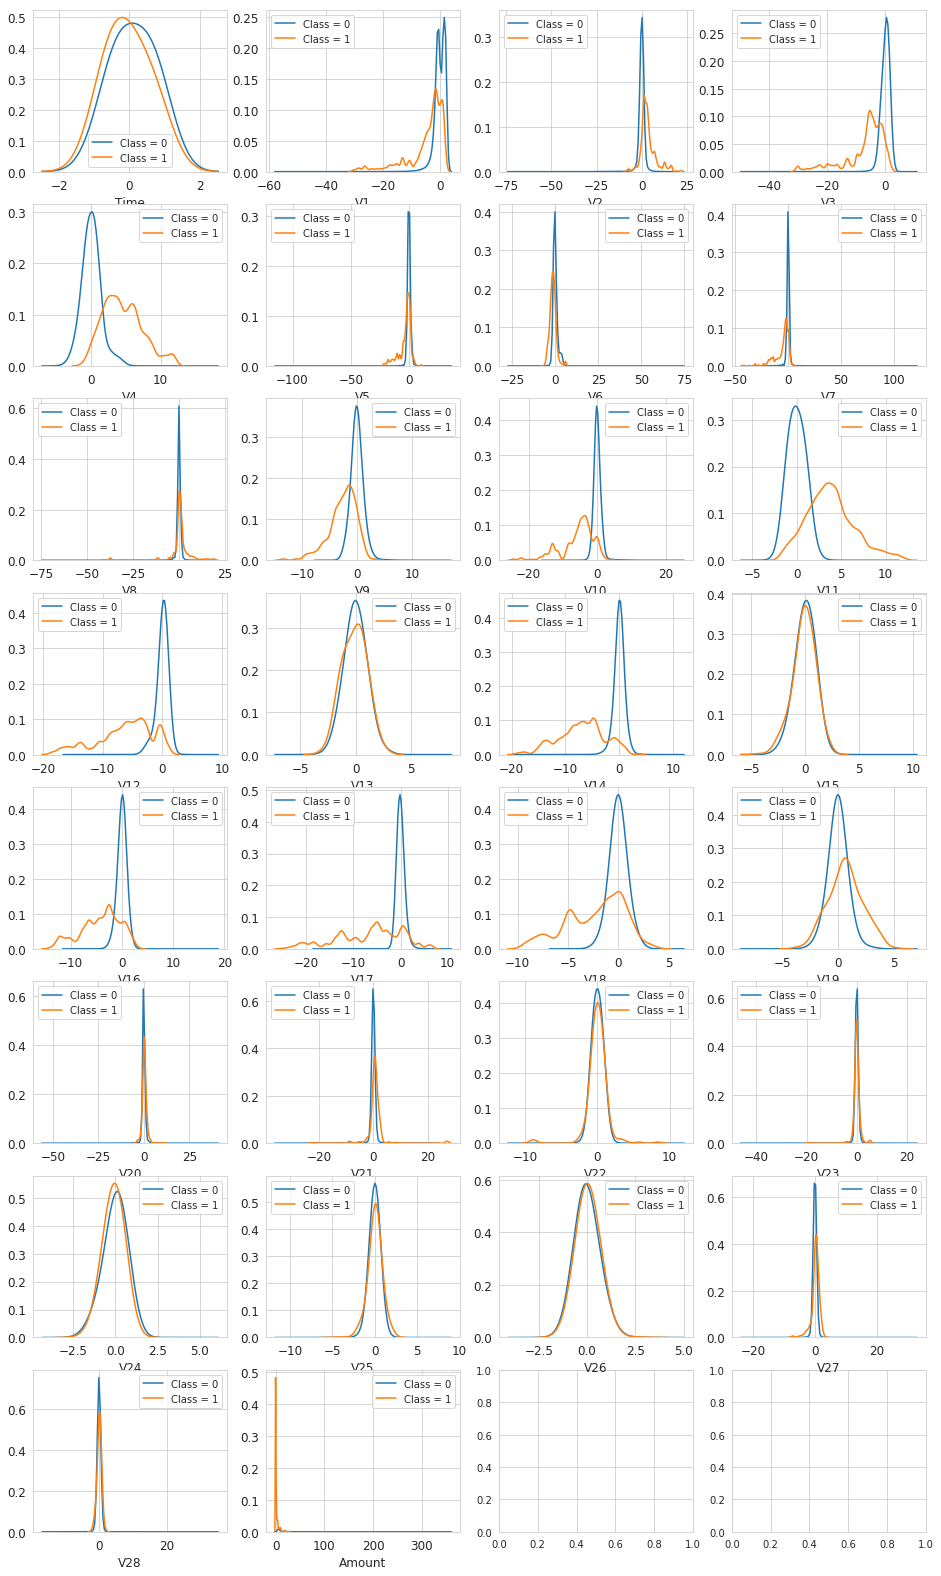

In [ ]:
i = 0
t0 = dataframe.loc[df['Class'] == 0]
t1 = dataframe.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in predictors:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();


We can see from the graph above that the distribution of fraud data points follows a very different distribution than normal in some features like V12, V14 and V17 for example. Using a gaussine mix to adjust normal labels can be a good idea indeed.

<h3> Preparation of Data </h3>

For semisupervised Learning, the train dataset is 80% of the all normal data points, while the test dataset is the same than supervised learning.

In [ ]:
df = dataframe.sample(frac=1, random_state=42)
fraude_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
fraude_df_test = df.loc[df['Class'] == 1][int(492*0.8):]

normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9:int(492*0.8*9)+int(284807*0.2)]

new_df_train_semisup= df.loc[df['Class'] == 0][:int(284807*.8)]
new_df_test = pd.concat([normal_df_test, fraude_df_test])

X_train_semisup = new_df_train_semisup.drop('Class', axis=1)
#X_train_semisup=X_train_semisup[['V4','V5', 'V7','V9','V10','V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount']]
X_test = new_df_test.drop('Class', axis=1)
#X_test=X_test[['V4','V5', 'V7','V9','V10','V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount']]
y_test = new_df_test['Class']


In [ ]:
X_train_semisup.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
49906,-0.474994,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,6.960386
29474,-0.578108,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0.125760
276481,0.968421,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.286453
278846,0.984281,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.294977
101565,-0.197535,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,...,0.618411,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,1.089918


Let's to do a model of gaussian mix with 3 gaussians. Using a best threshold to evaluate the f2 score, we can differentiate the normal data points of fraud data points.

The recall score is": 0.828
The precision score is": 0.672
The f2 score is": 0.792
The Kappa score is": 0.742
                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56966
 class 1 (Fraud)       0.67      0.83      0.74        99

        accuracy                           1.00     57065
       macro avg       0.84      0.91      0.87     57065
    weighted avg       1.00      1.00      1.00     57065



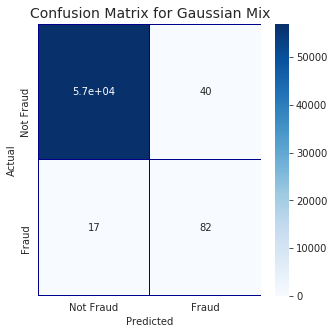

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=5)
gmm.fit(X_train_semisup)

prediction_MG = gmm.score_samples(X_test)

scores_MG = []
tresholds = np.linspace(-1000 , 100 , 200)

for treshold in tresholds:
    y_hat_MG = (prediction_MG < treshold).astype(int)
    scores_MG.append([metrics.recall_score(y_pred=y_hat_MG, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_MG, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_MG, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_MG, y2=y_test)])
    
scores_MG=np.array(scores_MG)
final_tresh = tresholds[scores_MG[:, 2].argmax()]
y_hat_MG = (prediction_MG < final_tresh).astype(int)
best_score = scores_MG[scores_MG[:, 2].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
cohen_kappa_score = best_score[3]

print('The recall score is": %.3f' % recall_score)
print('The precision score is": %.3f' % precision_score)
print('The f2 score is": %.3f' % fbeta_score)
print('The Kappa score is": %.3f' % cohen_kappa_score)
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_test, y_hat_MG, target_names=target_names))

cm = pd.crosstab(y_test, y_hat_MG, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Gaussian Mix', fontsize=14)
plt.show()


<h2>Isolation Forest </h2>

The main idea is that Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest, like any tree ensemble method, is built on the basis of decision trees. 

The isolation forest model is another universal approximation model of distributions. Thus, we do not need to put any restrictive assumptions on how data is distributed. This model is based on tree structures, a class of machine learning methods that has become very popular in recent years due to its intuitive simplicity and rapid training. The isolation forest model fits multiple isolation trees to the data. To build each isolation tree, we first randomly select one of the variables in the data. Then we select a random value between the maximum and minimum of this variable, which will be used to separate the data. We keep doing these random segmentations until all observations are isolated, that is, separate from the others.

Let's to build the isolation forest model,similarly to what we did with gaussian mixtures.

The recall score is": 0.616
The precision score is": 0.404
The f2 score is": 0.558
The Kappa score is": 0.487
                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56966
 class 1 (Fraud)       0.40      0.62      0.49        99

        accuracy                           1.00     57065
       macro avg       0.70      0.81      0.74     57065
    weighted avg       1.00      1.00      1.00     57065



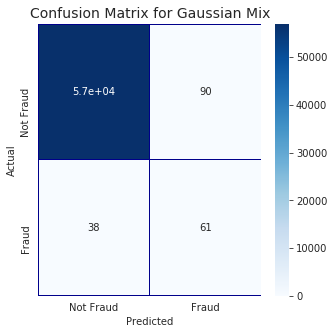

In [ ]:
model_IF = IsolationForest(random_state=42, n_jobs=4, max_samples=X_train_semisup.shape[0], bootstrap=False, n_estimators=100)
model_IF.fit(X_train_semisup)
tresholds = np.linspace(-.2, .2, 200)
prediction_IF = model_IF.decision_function(X_test)
scores_IF = []
for treshold in tresholds:
    y_hat_IF = (prediction_IF < treshold).astype(int)
    scores_IF.append([metrics.recall_score(y_pred=y_hat_IF, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_IF, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_IF, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_IF, y2=y_test)])
scores_IF=np.array(scores_IF)
a=scores_IF[:,2].argmax()
opt_trh=tresholds[a]
y_hat_IF = (prediction_IF < opt_trh).astype(int)
best_score = scores_IF[scores_IF[:, 2].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
cohen_kappa_score = best_score[3]

print('The recall score is": %.3f' % recall_score)
print('The precision score is": %.3f' % precision_score)
print('The f2 score is": %.3f' % fbeta_score)
print('The Kappa score is": %.3f' % cohen_kappa_score)
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_test, y_hat_IF, target_names=target_names))

cm = pd.crosstab(y_test, y_hat_IF, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Gaussian Mix', fontsize=14)
plt.show()


<h2> Autoencoders </h2>


Let's use a neural model called autoencoder, in which we ask a neural network to reconstruct the signal passed to it. We will ask the model to reconstruct normal data points and if we pass a fraud data point, it will have a big error which we will use to detect the fraud. In our case. The coded latent layer will have  25 neurons and since our data has 30 variables, this means that the neural network will have to learn an latent representation that condenses 30 dimensions in 25 dimensão going through representation with 100 and 50 neurons (30-100-50-25-50-100 layers).

It's not good use all the normal datapoints of the base, because the model need learn only how to detect frauds, not create a good generalization of normal data points. 
Have little points that represent normal data points is better. 


In [ ]:
from numpy.random import seed
seed(4)
input_dim = X_train_semisup.shape[1]

Input_layer=Input(shape=(input_dim,))
#encoder
encoding_dim = 100
from keras import initializers
#init = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=42)
#encoder
encoder=Dense(units=encoding_dim,activation='tanh', use_bias=False, 
              activity_regularizer=regularizers.l1(10e-5))(Input_layer)
encoder=BatchNormalization()(encoder)
encoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
encoder=Dense(units=int(encoding_dim/4), activation='relu')(encoder)

#decoder
decoder=Dense(units=int(encoding_dim/2), activation='relu')(encoder)
decoder=Dense(units=int(encoding_dim), activation='relu')(decoder)
decoder=Dense(units=input_dim,activation='relu')(decoder)


#modelo
autoencoder=Model(inputs=Input_layer,outputs=decoder)
encodermodel=Model(inputs=Input_layer,outputs=encoder)

epochs= 400
batch_size=128

#TensorBoard=TensorBoard(log_dir='./logs',histogram_freq=0,write_grads=True,write_images=True)
best_weights_filepath = './best_weights.hdf5'

earlyStopping=EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')

saveBestModel = ModelCheckpoint(best_weights_filepath, monitor='val_loss', 
                                verbose=1, save_best_only=True, mode='auto')
#we use 90% of data for train and 10% for validation
autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

history=autoencoder.fit(X_train_semisup[5000*0:5000*1],X_train_semisup[5000*0:5000*1],
                    epochs=epochs,batch_size=batch_size,shuffle=False,
                    validation_split=0.1,verbose=0, 
                    callbacks=[saveBestModel,earlyStopping]).history
autoencoder.load_weights(best_weights_filepath)
predictions_AE=autoencoder.predict(X_test)
#mse is the mean squared error between the original data points and the reconstruction data points
mse=np.mean(np.power(X_test - predictions_AE, 2), axis=1)



Epoch 00001: val_loss improved from inf to 1.53975, saving model to ./best_weights.hdf5

Epoch 00002: val_loss improved from 1.53975 to 1.36484, saving model to ./best_weights.hdf5

Epoch 00003: val_loss improved from 1.36484 to 1.25976, saving model to ./best_weights.hdf5

Epoch 00004: val_loss improved from 1.25976 to 1.17223, saving model to ./best_weights.hdf5

Epoch 00005: val_loss improved from 1.17223 to 1.10008, saving model to ./best_weights.hdf5

Epoch 00006: val_loss improved from 1.10008 to 1.04017, saving model to ./best_weights.hdf5

Epoch 00007: val_loss improved from 1.04017 to 0.98487, saving model to ./best_weights.hdf5

Epoch 00008: val_loss improved from 0.98487 to 0.93547, saving model to ./best_weights.hdf5

Epoch 00009: val_loss improved from 0.93547 to 0.90691, saving model to ./best_weights.hdf5

Epoch 00010: val_loss improved from 0.90691 to 0.87059, saving model to ./best_weights.hdf5

Epoch 00011: val_loss improved from 0.87059 to 0.83600, saving model to .

Text(0.5, 1.0, 'loss in train and validation split')

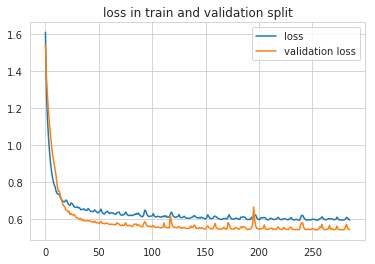

In [ ]:
#plotting the history of the model\qz
plt.figure()
plt.plot(history['loss'],label='loss')
plt.legend()
plt.plot(history['val_loss'],label='validation loss')
plt.legend()
plt.title('loss in train and validation split')

The recall score is": 0.808
The precision score is": 0.825
The f2 score is": 0.811
The Kappa score is": 0.816
                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56966
 class 1 (Fraud)       0.82      0.81      0.82        99

        accuracy                           1.00     57065
       macro avg       0.91      0.90      0.91     57065
    weighted avg       1.00      1.00      1.00     57065



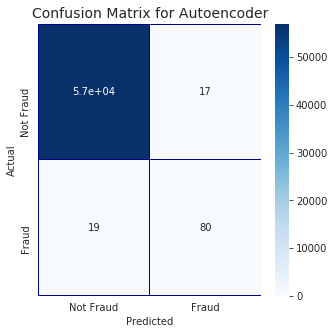

In [ ]:
fpr, tpr, tresholds = metrics.roc_curve(y_test, mse)
scores_AE=[]
for treshold in tresholds:
    y_hat_AE = (mse > treshold).astype(int)
    scores_AE.append([metrics.recall_score(y_pred=y_hat_AE, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_AE, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_AE, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_AE, y2=y_test)])

scores_AE = np.array(scores_AE)
final_tresh = tresholds[scores_AE[:, 2].argmax()]
y_hat_AE = (mse > final_tresh).astype(int)
best_score_AE = scores_AE[scores_AE[:, 2].argmax(),:]
recall_score_AE = best_score_AE[0]
precision_score_AE = best_score_AE[1]
fbeta_score_AE = best_score_AE[2]
cohen_kappa_score_AE = best_score_AE[3]

print('The recall score is": %.3f' % recall_score_AE)
print('The precision score is": %.3f' % precision_score_AE)
print('The f2 score is": %.3f' % fbeta_score_AE)
print('The Kappa score is": %.3f' % cohen_kappa_score_AE)
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_test, y_hat_AE, target_names=target_names))

cm = pd.crosstab(y_test, y_hat_AE, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Autoencoder', fontsize=14)
plt.show()

In the graph below, we can see the difference in data point reconstruction between normal and fraud classes.

Text(0.5, 1.0, 'Reconstruction error')

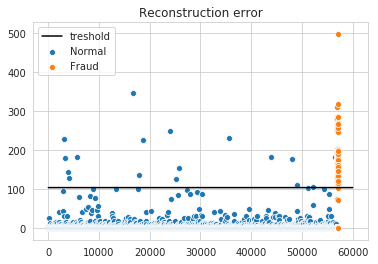

In [ ]:

y_test=np.array(y_test)
mse=np.array(mse)
error_df=pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})
t0 = error_df.loc[error_df['true_class'] == 0]
t1 = error_df.loc[error_df['true_class'] == 1]
t2=final_tresh*np.ones((60000,), dtype=int)
sns.scatterplot(data = t0['reconstruction_error'] ,label="Normal")
sns.lineplot(data=t2, color='black', label='treshold')
sns.scatterplot(data = t1['reconstruction_error'],label="Fraud").set_title('Reconstruction error')

1. <h2> Conclusion </h2>

The Autoencoder and Gaussian Mixture supervised learning models performed very well according to the f2 metric. Although not outperfomed the Random forest and XGBoost algorithms, the difference between the two methods was not significant.